In [30]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container {width:100% !important;}</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# %config Completer.use_jedi=False

%config IPCompleter.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import cv2
import yaml
import torch
import numpy as np
from pathlib import Path
import torchvision as tv
from torchvision.utils import make_grid
from ipywidgets import interact
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

import pytorch_tools as pt
from pytorch_tools.utils.misc import count_parameters

from src.arg_parser import TrainLoaderConfig, ValLoaderConfig
from src.dali_dataloader import DaliLoader
from src.model import CModel
# from src.angular_losses import SphereLinearLayer

count = lambda x: pt.utils.misc.count_parameters(x)[0]

2021-07-15 10:22:12.639 | WARNING  | pytorch_tools.modules:<module>:35 - Inplace ABN is not installed. Using ABN by default


# DALI loader (again)

### Cross covariance attention

In [1]:
import timm

In [3]:
xcit_timm = timm.models.xcit_tiny_12_p16_384_dist(pretrained=True)

Downloading: "https://dl.fbaipublicfiles.com/xcit/xcit_tiny_12_p16_384_dist.pth" to /home/zakirov/.cache/torch/hub/checkpoints/xcit_tiny_12_p16_384_dist.pth


In [6]:
for k, v in xcit_timm.state_dict().items():
    if 'temperature' in k:
        print(v)

tensor([[[0.2662]],

        [[0.3630]],

        [[0.3651]],

        [[0.6280]]])
tensor([[[1.0150]],

        [[0.9617]],

        [[0.8660]],

        [[0.5306]]])
tensor([[[1.5776]],

        [[1.1213]],

        [[1.1549]],

        [[1.0330]]])
tensor([[[0.9245]],

        [[1.5716]],

        [[1.4661]],

        [[1.2457]]])
tensor([[[1.4401]],

        [[0.8914]],

        [[1.4548]],

        [[1.2520]]])
tensor([[[1.2308]],

        [[1.4548]],

        [[1.0585]],

        [[0.9184]]])
tensor([[[1.4082]],

        [[1.3715]],

        [[0.7454]],

        [[0.8514]]])
tensor([[[0.8627]],

        [[0.9815]],

        [[1.5120]],

        [[1.3297]]])
tensor([[[1.0603]],

        [[0.8848]],

        [[1.5095]],

        [[1.0811]]])
tensor([[[1.2343]],

        [[1.3017]],

        [[1.2688]],

        [[1.1727]]])
tensor([[[1.1303]],

        [[1.3369]],

        [[1.1155]],

        [[1.0938]]])
tensor([[[1.2579]],

        [[1.2743]],

        [[1.1772]],

        [[1.1

In [104]:
class XCA(nn.Module):
    """ Cross-Covariance Attention (XCA)
    Operation where the channels are updated using a weighted sum. The weights are obtained from the (softmax
    normalized) Cross-covariance matrix (Q^T \\cdot K \\in d_h \\times d_h)
    """

    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
#         self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.temperature = torch.ones(num_heads, 1, 1)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        # Result of next line is (qkv, B, num (H)eads,  (C')hannels per head, N)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 4, 1)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        
        # Paper section 3.2 l2-Normalization and temperature scaling
        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)
        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # (B, H, C', N), permute -> (B, N, H, C')
        x = (attn @ v).permute(0, 3, 1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

from pytorch_tools.modules.residual import conv1x1

class MyXCA(nn.Module):
    """ Cross-Covariance Attention (XCA)
    Operation where the channels are updated using a weighted sum. The weights are obtained from the (softmax
    normalized) Cross-covariance matrix (Q^T \\cdot K \\in d_h \\times d_h)
    This could be viewed as dynamic 1x1 convolution
    """

    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
#         self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.temperature = torch.ones(num_heads, 1, 1)
        self.qkv = conv1x1(dim, dim * 3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = conv1x1(dim, dim, bias=True)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        # B, N, C = x.shape
        # Result of next line is (qkv, B, num (H)eads,  (C')hannels per head, N)
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 4, 1)
        # q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        
        B, C, H, W = x.shape
        # C` == channels per head, Hd == num heads
        # B x C x H x W -> B x 3*C x H x W -> B x 3 x Hd x C` x H*W -> 3 x B x Hd x C` x H*W
        qkv = self.qkv(x).reshape(B, 3, self.num_heads, C // self.num_heads, -1).transpose(0, 1)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy
        
        # Paper section 3.2 l2-Normalization and temperature scaling
        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)
        # -> B x Hd x C` x C`
        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        # B x Hd x C` x C` @ B x Hd x C` x H*W -> B x C x H x W
        x = (attn @ v).reshape(B, C, H, W)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
    def load_state_dict(self, state_dict):
        new_sd = {}
        for k, v in state_dict.items():
            if v.dim() == 2:
                new_sd[k] = v[..., None, None]
            else:
                new_sd[k] = v
        super().load_state_dict(new_sd)

BS = 2
DIM = 128
SIZE = 7
inp = torch.rand(BS, SIZE**2, DIM)
inp_img = inp.transpose(1, 2).reshape(BS, DIM, SIZE, SIZE)
xca_timm = XCA(DIM, num_heads=4)
xca_my = MyXCA(DIM, num_heads=4)

# load weights from Linear layer to conv1x1 layer
xca_my.load_state_dict(xca_timm.state_dict())

# make sure results are identical
out_timm = xca_timm(inp)
out_my = xca_my(inp_img)
out_timm_reshaped = out_timm.transpose(1, 2).reshape(BS, DIM, SIZE, SIZE)
assert torch.allclose(out_timm_reshaped, out_my, atol=1e-7)

In [3]:
model_args = {
    'stage_fns': ["simpl", "simpl", "simpl", "simpl"],                                                                                                  
    'block_fns': ["Pre_XX", "Pre_XX", "Pre_IR", "Pre_IR"],                                                                                              
    'stage_args': [
        {"dim_reduction": "stride & expand", "bottle_ratio": 1, "force_residual": True},
        {"dim_reduction": "stride & expand", "bottle_ratio": 1, "force_residual": True},
#         {"bottle_ratio": 1, "force_residual": True, "dw_str2_kernel_size": 9, "force_expansion": True},                                              
#         {"bottle_ratio": 1, "force_residual": True, "dw_str2_kernel_size": 9, "force_expansion": True},
        {"bottle_ratio": 1, "force_residual": True, "force_expansion": True},                                              
        {"bottle_ratio": 1, "force_residual": True, "force_expansion": True},
    ],
    'stem_width': 32,                                                                                                                                   
    'head_width': 2560 ,                                                                                                                                
    'norm_act': 'leaky_relu',                                                                                                                             
    'stem_type': 's2d',                                                                                                                                   
    'layers': [1, 2, 6, 5],                                                                                                                             
    'channels': [128, 192, 640, 1024],                                                                                                                  
    'head_type': 'default',
}

bmodel = pt.models.BNet(**model_args)
print(bmodel)

BNet(
  (stem_conv1): Sequential(
    (0): SpaceToDepth(block_size=2)
    (1): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): Identity()
  )
  (layer1): SimpleStage(
    (blocks): Sequential(
      (0): SimplePreActBasicBlock(
        (blurpool): BlurPool(channels=32)
        (bn1): ABN(32, eps=1e-05, momentum=0.1, affine=True, activation=ACT.LEAKY_RELU[0.01])
        (conv1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): ABN(128, eps=1e-05, momentum=0.1, affine=True, activation=ACT.LEAKY_RELU[0.01])
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
  )
  (layer2): SimpleStage(
    (blocks): Sequential(
      (0): SimplePreActBasicBlock(
        (blurpool): BlurPool(channels=128)
        (bn1): ABN(128, eps=1e-05, momentum=0.1, affine=True, activation=ACT.LEAKY_RELU[0.01])
        (conv1): Conv2d(128, 192, kernel_size=(3, 3), stride=(2, 2)

In [ ]:
gamma = 2
layer_config = [
    # my head
#     (-1, 1, "pt.modules.SpaceToDepth", 2),  # 0
#     (-1, 1, "scaled_conv3x3", (12, 64), {'gamma': gamma}),  # 0
#     (-1, 1, 'torch.nn.SiLU', (), {'inplace':True}),
#     (-1, 1, "scaled_conv3x3", (64, 128), {'gamma': gamma, 'stride': 2}),  # 0
    # timm head
    (-1, 1, "scaled_conv3x3", (3, 16), {'stride': 2}),
    (-1, 1, 'torch.nn.SiLU', (), {'inplace':True}),
    (-1, 1, "scaled_conv3x3", (16, 32)),
    (-1, 1, 'torch.nn.SiLU', (), {'inplace':True}),
    (-1, 1, "scaled_conv3x3", (32, 64)),
    (-1, 1, 'torch.nn.SiLU', (), {'inplace':True}),
    (-1, 1, "scaled_conv3x3", (64, 128), {'stride':  2}),
    # stage 1
#     (-1, 1, "pt.modules.BlurPool", 128),
    (-1, 1, "NormFreeBlockTimm", (128, 256, 64)),
    
    # stage 2
    (-1, 1, "pt.modules.BlurPool", 256),
    (-1, 1, "NormFreeBlockTimm", (256, 512, 128)),
    (-1, 1, "NormFreeBlockTimm", (512, 512, 128)),
#     # stage 3
    (-1, 1, "pt.modules.BlurPool", 512),
    (-1, 1, "NormFreeBlockTimm", (512, 1536, 384)),
    (-1, 5, "NormFreeBlockTimm", (1536, 1536, 384)),
#     # stage 4
    (-1, 1, "pt.modules.BlurPool", 1536),
    (-1, 3, "NormFreeBlockTimm", (1536, 1536, 384)),
#     (-1, 4, "NormFreeBlock", (384, 384)),
# #     # head
    (-1, 1, "ScaledStdConv2d", (1536, 2304, 1), {'padding': 1, 'gamma': gamma}),
    (-1, 1, 'torch.nn.SiLU', (), {'inplace':True}),
    (-1, 1, "pt.modules.FastGlobalAvgPool2d", (), dict(flatten=True)),
    (-1, 1, "nn.Linear", (2304, 1000)),
]


extra_kwargs = {
    'NormFreeBlockTimm': {
        'activation': "'silu'", 'groups_width': 64,
        'alpha': 0.2, 'gamma': gamma, 'attention_type': "'eca9'",
        'keep_prob': 0.8},
    'scaled_conv3x3': {'gamma': gamma}
}

cmodel = CModel(layer_config, extra_kwargs)
# print(cmodel)
# cmodel(torch.randn(1, 3, 224, 224)).shape

In [26]:
cmodel._patch_drop_path()

In [27]:
cmodel

CModel(
  (layers): ModuleList(
    (0): ScaledStdConv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), gamma=2)
    (1): SiLU(inplace=True)
    (2): ScaledStdConv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gamma=2)
    (3): SiLU(inplace=True)
    (4): ScaledStdConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gamma=2)
    (5): SiLU(inplace=True)
    (6): ScaledStdConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), gamma=2)
    (7): NormFreeBlockTimm(
      (block): Sequential(
        (act1): SiLU()
        (conv1): ScaledStdConv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), gamma=2)
        (act2): SiLU(inplace=True)
        (conv2): ScaledStdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gamma=2)
        (act2b): SiLU(inplace=True)
        (conv2b): ScaledStdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gamma=2)
        (attn1): Identity()
        (act3): SiLU(inplace=True)
        (co

In [13]:
keep_probs = [m.keep_prob for n, m in cmodel.named_modules() if 'drop_path' in n]
max_keep_prob = max(keep_probs)
num_drop_layers = len(keep_probs)

In [41]:
count(cmodel) + 128 * 256 + 256 * 512 + 512 * 1536 + 1536 * 1536, count(eca_nfn)

(24136292, 24143924)

In [26]:
# sd = torch.load("/home/zakirov/repoz/sota_imagenet/logs/2021-07-02_cnet_no-dim-red_nov/10-37-30/model.chpn")['state_dict']
# my nfnet
sd = torch.load("/home/zakirov/repoz/sota_imagenet/logs/2021-07-08_nf-cnet_more-heads/11-23/model.chpn", map_location='cpu')['state_dict']
# timm nfnet stem
# sd = torch.load("/home/zakirov/repoz/sota_imagenet/logs/2021-07-08_eca-nfnet-l0_long-more-aug/11-06/model.chpn", map_location='cpu')['state_dict']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


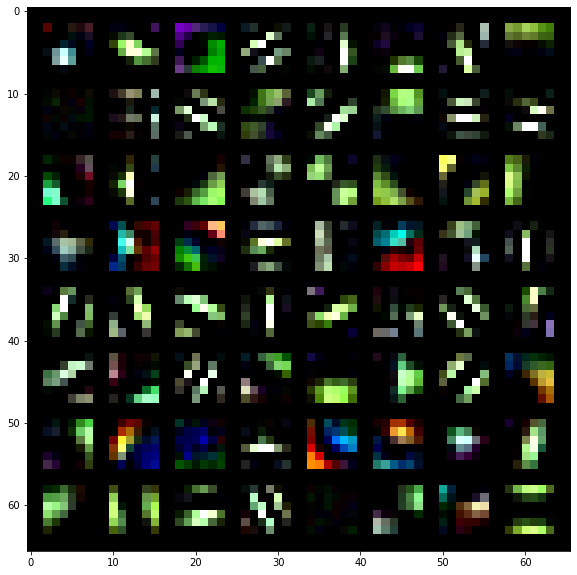

In [27]:
ww = sd['layers.1.weight']
ww2 = ww.view(64, 2, 2, 3, 3, 3).permute(0, 3, 4, 1, 5, 2).reshape(64, 3, 6, 6)
grid = make_grid(ww2.mul(2)).permute(1, 2, 0)

# grid = make_grid(sd['stem.conv1.weight'].mul(3)).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(grid)

In [70]:
from copy import deepcopy

GLOBAL_MEAN = []
GLOBAL_STD = []

def get_hook(name):
    def hook(self, inp, out):
        inp_mean = inp[0].mean(dim=(0, 2, 3)).pow(2).mean().sqrt().item()
        out_mean = out.mean(dim=(0, 2, 3)).pow(2).mean().sqrt().item()
        print(f"{name:50} Std inp: {inp[0].std().item():6.3f} Std out: {out.std().item():6.3f}",
              f"Mean sq inp: {inp_mean:.3f} Mean sq out: {out_mean:.3f}")
        GLOBAL_MEAN.append(inp_mean)
        GLOBAL_MEAN.append(out_mean)
        GLOBAL_STD.append(inp[0].std().item())
        GLOBAL_STD.append(out.std().item())
    return hook
        
def add_hooks(model):
    for name, m in model.named_modules():
        if not isinstance(m, torch.nn.Conv2d):
            continue
        if "fc" in name:
            continue
        m.register_forward_hook(get_hook(name))
    return model

In [71]:
# bmodel = bmodel.eval().requires_grad_(False) # .cuda()
cmodel = cmodel.eval().requires_grad_(False) # .cuda()
inp = torch.randn(2, 3, 256, 256) #.cuda()

# Speed test

In [3]:
from torch.utils import benchmark
torch.cuda.benchmark=True

In [13]:
chs = 128
inp = torch.rand(32, chs, 112, 112)
conv = nn.Conv2d(chs, chs, 3, 1, groups=1, bias=False)
conv_dw = nn.Conv2d(chs, chs, 3, 1, groups=chs, bias=False)
conv_gr2 = nn.Conv2d(chs, chs, 3, 1, groups=2, bias=False)
conv_gr4 = nn.Conv2d(chs, chs, 3, 1, groups=4, bias=False)
conv_gr8 = nn.Conv2d(chs, chs, 3, 1, groups=8, bias=False)
conv_gr16 = nn.Conv2d(chs, chs, 3, 1, groups=16, bias=False)


count(conv), count(conv_dw), count(conv_gr2), count(conv_gr4), count(conv_gr8), count(conv_gr16)

(147456, 1152, 73728, 36864, 18432, 9216)

In [14]:
inp, conv, conv_dw, conv_gr2, conv_gr4 = inp.cuda(), conv.cuda(), conv_dw.cuda(), conv_gr2.cuda(), conv_gr4.cuda()
conv_gr8, conv_gr16 = conv_gr8.cuda(), conv_gr16.cuda()

# inp, conv, conv_dw, conv_gr2, conv_gr4 = inp.half(), conv.half(), conv_dw.half(), conv_gr2.half(), conv_gr4.half()
# conv_gr8, conv_gr16 = conv_gr8.half(), conv_gr16.half()

In [15]:
all_res = []

label = f"Inp shape: {inp.shape}"
all_res.append(
    benchmark.Timer(
        stmt='conv(inp)',
        globals={'inp': inp, 'conv': conv},
        label=label,
        sub_label="full conv",
        description='description',
    ).blocked_autorange(min_run_time=1)
)

all_res.append(
    benchmark.Timer(
        stmt='conv(inp)',
        globals={'inp': inp, 'conv': conv_dw},
        label=label,
        sub_label="dw conv",
        description='description',
    ).blocked_autorange(min_run_time=1)
)

all_res.append(
    benchmark.Timer(
        stmt='conv(inp)',
        globals={'inp': inp, 'conv': conv_gr2},
        label=label,
        sub_label="conv gr=2",
        description='description',
    ).blocked_autorange(min_run_time=1)
)

all_res.append(
    benchmark.Timer(
        stmt='conv(inp)',
        globals={'inp': inp, 'conv': conv_gr4},
        label=label,
        sub_label="conv gr=4",
        description='description',
    ).blocked_autorange(min_run_time=1)
)

all_res.append(
    benchmark.Timer(
        stmt='conv(inp)',
        globals={'inp': inp, 'conv': conv_gr8},
        label=label,
        sub_label="conv gr=8",
        description='description',
    ).blocked_autorange(min_run_time=1)
)

all_res.append(
    benchmark.Timer(
        stmt='conv(inp)',
        globals={'inp': inp, 'conv': conv_gr16},
        label=label,
        sub_label="conv gr=16",
        description='description',
    ).blocked_autorange(min_run_time=1)
)

benchmark.Compare(all_res).print()

[ Inp shape: torch.Size([32, 128, 112, 112]) ]
                  |  description
1 threads: ---------------------
      full conv   |     4484.0  
      dw conv     |      903.5  
      conv gr=2   |     3377.1  
      conv gr=4   |     2212.1  
      conv gr=8   |     2178.7  
      conv gr=16  |     2438.9  

Times are in microseconds (us).



In [59]:
chs = 16
tt = torch.ones(1, chs, 3, 3) * torch.arange(chs).view(1, -1, 1, 1) 
# tt.view(1, 2, 2, 3, 3).transpose(1, 2).reshape_as(tt)

class ChannelShuffle(nn.Module):
    """shuffles groups inside tensor. used to mix channels after grouped convolution. this is cheaper than using conv1x1
    Ref: ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices 
    """
    def __init__(self, groups=1):
        super().__init__()
        self.groups = groups
        
    def forward(self, x):
        BS, CHS, H, W = x.shape
        GR = self.groups
        return x.view(BS, GR, CHS // GR, H, W).transpose(1, 2).reshape_as(x)
    
    def extra_repr(self):
        return f"groups={self.groups}"
    
ShuffleBlock(4)(tt)[:, :, 0, 0]

tensor([[ 0.,  4.,  8., 12.,  1.,  5.,  9., 13.,  2.,  6., 10., 14.,  3.,  7.,
         11., 15.]])

In [21]:
cmodel = CModel(layer_config, extra_kwargs)
pt.utils.misc.initialize(cmodel, gamma=1.71)
for m in cmodel.modules():
    if isinstance(m, torch.nn.Conv2d):
        m.weight.data.copy_(pt.utils.misc.normalize_conv_weight(m.weight, gamma=1.4))
cmodel_c = add_hooks(deepcopy(cmodel))
out_c = cmodel_c(inp)
out_c.mean(), out_c.std()

layers.1                                           Std inp:  1.000 Std out:  1.393 Mean sq inp: 0.006 Mean sq out: 0.008
layers.4.block.conv1                               Std inp:  0.659 Std out:  0.912 Mean sq inp: 0.164 Mean sq out: 0.003
layers.4.block.conv2                               Std inp:  0.553 Std out:  0.768 Mean sq inp: 0.166 Mean sq out: 0.003
layers.6.block.conv1                               Std inp:  0.557 Std out:  0.768 Mean sq inp: 0.166 Mean sq out: 0.007
layers.6.block.conv2                               Std inp:  0.556 Std out:  0.764 Mean sq inp: 0.166 Mean sq out: 0.007
layers.7.block.conv1                               Std inp:  0.556 Std out:  0.765 Mean sq inp: 0.166 Mean sq out: 0.006
layers.7.block.conv2                               Std inp:  0.556 Std out:  0.766 Mean sq inp: 0.166 Mean sq out: 0.005
layers.9.block.conv_pw                             Std inp:  0.559 Std out:  0.779 Mean sq inp: 0.166 Mean sq out: 0.001
layers.9.block.conv_dw          

(tensor(-0.0193, grad_fn=<MeanBackward0>),
 tensor(0.3187, grad_fn=<StdBackward0>))

In [111]:
pt.utils.misc.initialize(cmodel, gamma=1.72)

In [41]:
a = torch.rand(32, 32, 3, 3)
b = torch.rand(32, 32, 3, 3)

In [42]:
torch.cosine_similarity(a, b, dim=0)

tensor([[[0.8012, 0.7348, 0.8082],
         [0.7242, 0.8003, 0.7613],
         [0.8076, 0.7144, 0.7416]],

        [[0.7694, 0.8173, 0.6806],
         [0.7535, 0.7968, 0.7089],
         [0.8186, 0.8242, 0.7939]],

        [[0.8123, 0.7816, 0.8025],
         [0.7405, 0.8633, 0.7254],
         [0.6045, 0.7529, 0.7720]],

        [[0.8167, 0.8032, 0.7029],
         [0.8257, 0.7886, 0.6659],
         [0.7925, 0.7823, 0.7656]],

        [[0.7993, 0.7661, 0.6866],
         [0.7777, 0.8966, 0.7704],
         [0.7934, 0.7844, 0.7406]],

        [[0.8684, 0.7242, 0.7841],
         [0.6860, 0.7903, 0.7761],
         [0.7583, 0.7365, 0.7481]],

        [[0.6257, 0.7125, 0.6632],
         [0.7722, 0.6812, 0.7651],
         [0.7227, 0.7713, 0.8075]],

        [[0.8311, 0.7061, 0.7390],
         [0.6867, 0.7756, 0.7631],
         [0.7374, 0.7458, 0.7617]],

        [[0.7782, 0.8310, 0.7467],
         [0.7896, 0.8115, 0.8354],
         [0.7674, 0.7935, 0.7648]],

        [[0.7444, 0.8900, 0.6991],
  

In [43]:
torch.maximum?

In [ ]:
torch._for

In [40]:
(a * a).sum().sqrt()

tensor(5.9401)

In [35]:
a.norm(2)

tensor(5.9401)

In [33]:
(1 + a @ b.T / (a.norm(p=2) * b.norm(p=2)))

tensor(1.7168)

In [95]:
cmodel_c = add_hooks(deepcopy(cmodel))
out_c = cmodel_c(inp)
out_c.mean(), out_c.std()

layers.1                                           Std inp:  1.001 Std out:  1.758 Mean sq inp: 0.006 Mean sq out: 0.009
layers.3.block.conv1                               Std inp:  0.551 Std out:  0.973 Mean sq inp: 0.166 Mean sq out: 0.267
layers.3.block.conv2                               Std inp:  0.553 Std out:  1.001 Mean sq inp: 0.166 Mean sq out: 0.304
layers.5.block.conv1                               Std inp:  0.553 Std out:  0.977 Mean sq inp: 0.166 Mean sq out: 0.262
layers.5.block.conv2                               Std inp:  0.553 Std out:  0.986 Mean sq inp: 0.166 Mean sq out: 0.299
layers.6.block.conv1                               Std inp:  0.555 Std out:  0.990 Mean sq inp: 0.166 Mean sq out: 0.297
layers.6.block.conv2                               Std inp:  0.556 Std out:  0.989 Mean sq inp: 0.166 Mean sq out: 0.283
layers.8.block.conv_pw                             Std inp:  0.555 Std out:  0.988 Mean sq inp: 0.166 Mean sq out: 0.274
layers.8.block.conv_dw          

(tensor(-0.0109, grad_fn=<MeanBackward0>),
 tensor(0.3419, grad_fn=<StdBackward0>))

In [47]:
cmodel_c = add_hooks(deepcopy(cmodel))
out_c = cmodel_c(inp)
out_c.mean(), out_c.std()

layers.1                                           Std inp:  1.001 Std out:  0.567 Mean sq inp: 0.006 Mean sq out: 0.003
layers.3.block.conv1                               Std inp:  0.551 Std out:  0.331 Mean sq inp: 0.166 Mean sq out: 0.097
layers.3.block.conv2                               Std inp:  0.552 Std out:  0.329 Mean sq inp: 0.166 Mean sq out: 0.094
layers.5.block.conv1                               Std inp:  0.553 Std out:  0.328 Mean sq inp: 0.166 Mean sq out: 0.093
layers.5.block.conv2                               Std inp:  0.554 Std out:  0.327 Mean sq inp: 0.166 Mean sq out: 0.086
layers.6.block.conv1                               Std inp:  0.554 Std out:  0.330 Mean sq inp: 0.166 Mean sq out: 0.095
layers.6.block.conv2                               Std inp:  0.554 Std out:  0.333 Mean sq inp: 0.166 Mean sq out: 0.101
layers.8.block.conv_pw                             Std inp:  0.552 Std out:  0.335 Mean sq inp: 0.166 Mean sq out: 0.100
layers.8.block.conv_dw          

(tensor(-0.0009, grad_fn=<MeanBackward0>),
 tensor(0.1229, grad_fn=<StdBackward0>))

In [22]:
out_b = bmodel(inp)
out_b.mean(), out_b.std()

(tensor(-0.0280), tensor(4.2089))

In [53]:
import timm.models as t_models

In [56]:
eca_nfn = t_models.nfnet.eca_nfnet_l0(drop_rate=0., drop_path_rate=0.1).eval().requires_grad_(False) #.cuda()

In [65]:
sum(['drop_path' in n for n, m in cmodel.layers.named_modules()])

0

In [57]:
for n, m in eca_nfn.named_modules():
    if 'drop_path' in n and not isinstance(m, nn.Identity):
        print(m.drop_prob)

0.00909090880304575
0.0181818176060915
0.027272727340459824
0.036363635212183
0.045454543083906174
0.054545458406209946
0.06363636255264282
0.0727272778749466
0.08181818574666977
0.09090909361839294
0.10000000149011612


In [58]:
cmodel

CModel(
  (layers): ModuleList(
    (0): ScaledStdConv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), gamma=2)
    (1): SiLU(inplace=True)
    (2): ScaledStdConv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gamma=2)
    (3): SiLU(inplace=True)
    (4): ScaledStdConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gamma=2)
    (5): SiLU(inplace=True)
    (6): ScaledStdConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), gamma=2)
    (7): NormFreeBlockTimm(
      (block): Sequential(
        (act1): SiLU()
        (conv1): ScaledStdConv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), gamma=2)
        (act2): SiLU(inplace=True)
        (conv2): ScaledStdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gamma=2)
        (act2b): SiLU(inplace=True)
        (conv2b): ScaledStdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gamma=2)
        (act3): SiLU(inplace=True)
        (conv3): ScaledStdConv2d(64, 25

In [ ]:
torch.nn.Mul

In [221]:
torch.rand(1, 1, 64, 64, 64).sum(1)

tensor([[[[0.1488, 0.5168, 0.9955,  ..., 0.6991, 0.7772, 0.1361],
          [0.8709, 0.4912, 0.2828,  ..., 0.4357, 0.7349, 0.0489],
          [0.0529, 0.4523, 0.2043,  ..., 0.9837, 0.9415, 0.7982],
          ...,
          [0.6445, 0.2171, 0.1749,  ..., 0.3039, 0.5345, 0.2204],
          [0.0019, 0.5523, 0.9127,  ..., 0.9959, 0.0584, 0.6635],
          [0.2139, 0.2612, 0.7626,  ..., 0.3806, 0.8796, 0.5739]],

         [[0.5118, 0.2998, 0.5076,  ..., 0.5690, 0.5301, 0.8728],
          [0.0399, 0.2366, 0.8561,  ..., 0.2039, 0.6909, 0.5913],
          [0.3134, 0.6069, 0.0126,  ..., 0.7219, 0.1351, 0.0867],
          ...,
          [0.7287, 0.9760, 0.5913,  ..., 0.6469, 0.1150, 0.8815],
          [0.4959, 0.5051, 0.5066,  ..., 0.0480, 0.8511, 0.6140],
          [0.0359, 0.6722, 0.6517,  ..., 0.8763, 0.8884, 0.1898]],

         [[0.6846, 0.4093, 0.3907,  ..., 0.2864, 0.1841, 0.6847],
          [0.5838, 0.5391, 0.3505,  ..., 0.7466, 0.8020, 0.0729],
          [0.6126, 0.6496, 0.1106,  ..., 0

In [22]:
1024 * 1024 * 9

9437184

In [33]:
count(pt.models.resnet34().layer4)

13114368

In [34]:
count(nn.Conv2d(1024, 1024, 3, groups=16))

590848

In [21]:
bb = NormFreeBlock(256, 256, groups_width=64, activation='silu')
print(bb(torch.rand(1, 256, 24, 24)).shape)
bb

torch.Size([1, 256, 24, 24])


NormFreeBlock(
  (block): Sequential(
    (act1): SiLU(inplace=True)
    (conv1): ScaledStdConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4)
    (shuffle1): ChannelShuffle(groups=4)
    (act2): SiLU(inplace=True)
    (conv2): ScaledStdConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4)
    (shuffle2): ChannelShuffle(groups=4)
    (droppath): Identity()
  )
)

In [ ]:
ScaledStdConv2d(32, 64, 3, )

In [61]:
eca_nfn.stages[0][0].skipinit_gain

In [49]:
eca_nfn

[autoreload of pytorch_tools.modules.activations failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-

NormFreeNet(
  (stem): Sequential(
    (conv1): ScaledStdConv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act2): SiLU(inplace=True)
    (conv2): ScaledStdConv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act3): SiLU(inplace=True)
    (conv3): ScaledStdConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act4): SiLU(inplace=True)
    (conv4): ScaledStdConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (stages): Sequential(
    (0): Sequential(
      (0): NormFreeBlock(
        (downsample): DownsampleAvg(
          (pool): Identity()
          (conv): ScaledStdConv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
        )
        (act1): SiLU()
        (conv1): ScaledStdConv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (act2): SiLU(inplace=True)
        (conv2): ScaledStdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act2b): SiLU(inplace=True)
        (conv2b): ScaledStd

In [68]:
class Foo(torch.nn.Module):
    def forward(self, x):
        return pt.utils.misc.zero_mean_conv_weight(x)

In [28]:
eca_nfn.stem.conv4.weight.mean()

tensor(-0.0002)

In [52]:
oo = pt.modules.BlurPool(16)(torch.randn(4, 16, 112, 112))
torch.nn.SELU()(oo).std()

tensor(0.4474)

In [ ]:
pt.modules.residual.RepVGGBlock

In [70]:
layer_config = [
    (-1, 1, "pt.modules.SpaceToDepth", 2),  # 0
    (-1, 1, "conv3x3", (12, 64)),  # 0
    (-1, 1, 'torch.nn.SELU'),
    
    (-1, 1, "pt.modules.BlurPool", 64),
    (-1, 4, "pt.modules.residual.RepVGGBlock", (64, 64)),
    
    (-1, 1, "pt.modules.BlurPool", 64),
    (-1, 1, "pt.modules.residual.RepVGGBlock", (64, 128)),
    (-1, 5, "pt.modules.residual.RepVGGBlock", (128, 128)),
    
    (-1, 1, "pt.modules.BlurPool", 128),
    (-1, 1, "pt.modules.residual.RepVGGBlock", (128, 256)),
    (-1, 11, "pt.modules.residual.RepVGGBlock", (256, 256)),
    
#     (-1, 1, "pt.modules.BlurPool", 256),
#     (-1, 1, "pt.modules.residual.FusedRepVGGBlock", (256, 512)),
#     (-1, 5, "pt.modules.residual.FusedRepVGGBlock", (512, 512)),
#     (-1, 1, "pt.modules.FastGlobalAvgPool2d", (), dict(flatten=True)),
#     (-1, 1, "nn.Dropout", (), dict(p=0, inplace=False)),
#     (-1, 1, "nn.Linear", (512, 1000)),
]


extra_kwargs = {
    'PreBasicBlock': {'norm_act': "'swish_hard'"},
    'PreInvertedResidual': {'norm_act': "'swish_hard'"}
}

cmodel = CModel(layer_config, extra_kwargs)

for m in cmodel.modules():
    # turn to ScaledStdConv only usual (not DW) convs
    if isinstance(m, torch.nn.Conv2d) and m.groups == 1:
        torch.nn.utils.parametrize.register_parametrization(m, 'weight', Foo())
# print(cmodel)
# cmodel(torch.randn(1, 3, 224, 224)).shape

In [72]:
out.mean()

tensor(-0.7970, grad_fn=<MeanBackward0>)

In [45]:
torch.nn.utils.parametrize.remove_parametrizations(eca_nfn.stem.conv4, 'weight', leave_parametrized=True)

ScaledStdConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [44]:
cc_p = torch.nn.utils.parametrize.register_parametrization(eca_nfn.stem.conv4, 'weight', Foo())
cc_p

ParametrizedScaledStdConv2d(
  64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): Foo()
    )
  )
)

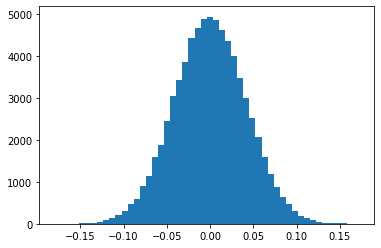

In [46]:
plt.hist(eca_nfn.stem.conv4.weight.flatten().detach(), bins=50);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


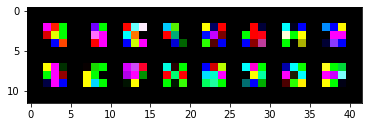

In [42]:
plt.imshow(make_grid(eca_nfn.stem.conv1.weight).transpose(0, 2).transpose(0, 1).detach().mul(10))

In [20]:
inp = torch.randn(32, 3, 224, 224).cuda()

In [24]:
out = eca_nfn(inp)

In [25]:
out.mean(), out.std()

(tensor(-0.0004, device='cuda:0'), tensor(0.1906, device='cuda:0'))

In [24]:
t0 = benchmark.Timer(
    stmt='model(inp)',
    globals={'inp': inp, 'model': bmodel},
    label='some label',
    sub_label=f'BModel (old)',
    description='description',
).blocked_autorange(min_run_time=1)

t1 = benchmark.Timer(
    stmt='model(inp)',
    globals={'inp': inp, 'model': cmodel},
    label='some label',
    sub_label=f'CModel (new)',
    description='description',
).blocked_autorange(min_run_time=1)

benchmark.Compare([t0, t1]).print()

[---------- some label ----------]
                    |  description
1 threads: -----------------------
      BModel (old)  |      46.0   
      CModel (new)  |      41.0   

Times are in milliseconds (ms).



In [28]:
m = pt.models.resnet50().eval().requires_grad_(False)
m_i = pt.models.resnet50(pretrained='imagenet').eval().requires_grad_(False)

# patch_bn_mom(m, 0.02)

In [6]:
from torch.utils.tensorboard import SummaryWriter

In [53]:
with SummaryWriter("/home/zakirov/repoz/test_logs/") as writer:
    for n, p in m.named_parameters():
        writer.add_histogram(f'model/{n}', p.flatten(), global_step=0)

#     for n, p in m_i.named_parameters():
#         writer.add_histogram(f'model/{n}', p.half().flatten(), global_step=100)


In [50]:
writer.close()

In [30]:
writer.close()

In [52]:
!rm /home/zakirov/repoz/test_logs/*

In [51]:
!ls -lsh /home/zakirov/repoz/test_logs

total 2.6M
1.6M -rw-rw-r-- 1 zakirov zakirov 1.6M Jul  1 18:26 events.out.tfevents.1625153172.devbox7.16771.5
488K -rw-rw-r-- 1 zakirov zakirov 485K Jul  1 18:32 events.out.tfevents.1625153524.devbox7.16771.6
488K -rw-rw-r-- 1 zakirov zakirov 485K Jul  1 18:32 events.out.tfevents.1625153543.devbox7.16771.7


In [17]:
writer.add_scalar('test/some', 10, global_step=10)
writer.add_scalar('test/some', 20, global_step=20)

In [6]:
BS = 16
NUM_WORKERS = 4
# pipe = train_pipeline(batch_size=BS, num_threads=1, device_id=0)
# pipe.build()


In [15]:
cfg = TrainLoaderConfig(
    batch_size=64,
#     color_twist_prob=0.1,
    gray_prob=1,
#     re_prob=0.2,
#     re_count=4,
    use_tfrecords=True,
    root_data_dir=Path('/mnt/storage/datasets/ImageNet/raw-data/')
)

# cfg = ValLoaderConfig(
#     batch_size=8,
#     use_tfrecords=True,
#     root_data_dir=Path('/mnt/storage/datasets/ImageNet/raw-data/')
# )
loader = DaliLoader(cfg=cfg)
batch = next(iter(loader))

In [81]:
cc = torch.nn.Conv2d(32, 64, 3)
w = cc.weight

In [90]:
w.data.sub_(w.mean(dim=(1, 2, 3), keepdim=True))

tensor([[[[ 0.0204,  0.0411,  0.0396],
          [ 0.0403,  0.0412,  0.0357],
          [-0.0428, -0.0641,  0.0370]],

         [[ 0.0062,  0.0027, -0.0123],
          [-0.0288,  0.0139, -0.0534],
          [ 0.0468,  0.0482, -0.0246]],

         [[ 0.0369,  0.0235,  0.0465],
          [ 0.0087,  0.0159, -0.0272],
          [-0.0298, -0.0102,  0.0513]],

         ...,

         [[-0.0638,  0.0185, -0.0417],
          [-0.0181,  0.0398, -0.0562],
          [ 0.0026,  0.0528, -0.0428]],

         [[ 0.0259,  0.0312,  0.0466],
          [ 0.0129,  0.0262, -0.0566],
          [ 0.0231,  0.0468, -0.0238]],

         [[ 0.0025,  0.0337,  0.0039],
          [ 0.0273, -0.0217,  0.0037],
          [-0.0021,  0.0083,  0.0026]]],


        [[[-0.0095, -0.0084, -0.0314],
          [ 0.0042,  0.0140, -0.0086],
          [ 0.0087, -0.0032, -0.0204]],

         [[-0.0478,  0.0474, -0.0509],
          [ 0.0215, -0.0216, -0.0029],
          [ 0.0508, -0.0522, -0.0191]],

         [[-0.0132,  0.0383,  0

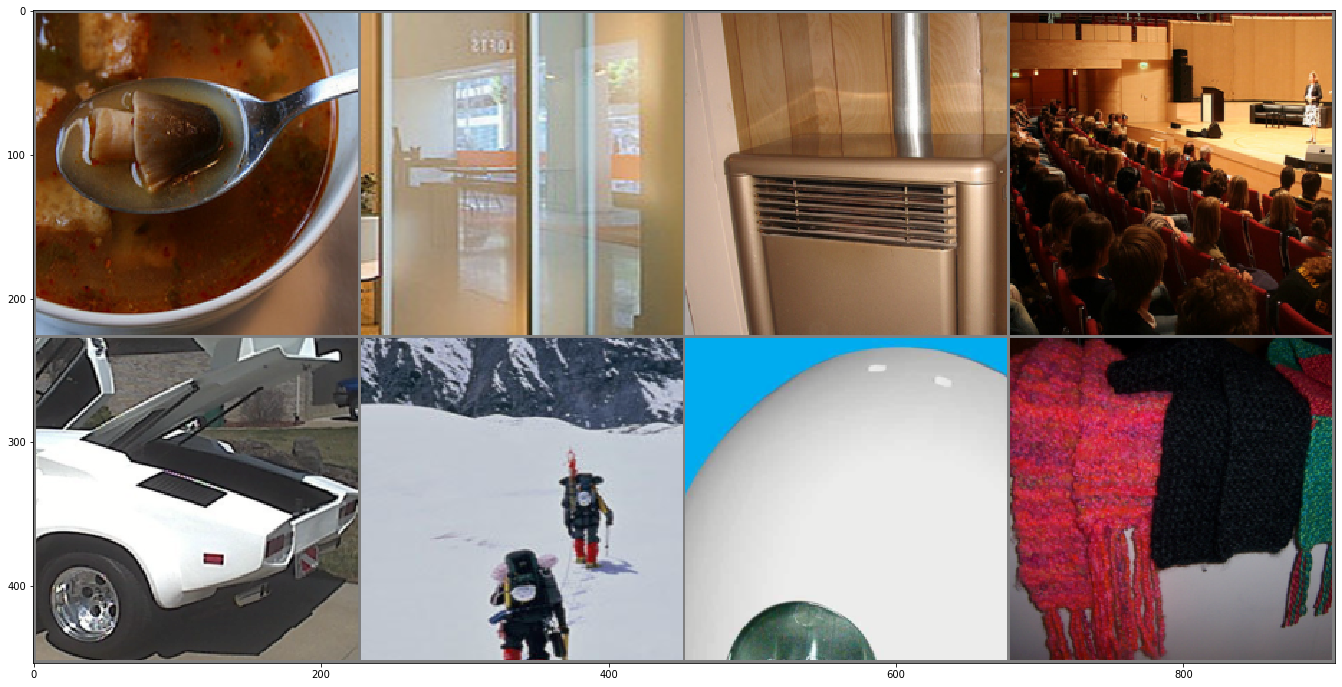

In [10]:
def show_batch(batch):
    batch = make_grid(batch.cpu(), nrow=4).transpose(-1, -2).transpose(-1, -3).numpy()
    batch = (batch * 0.2 + 0.5)    
    plt.imshow(batch)

plt.figure(figsize=(24, 12))
show_batch(batch[0])

In [117]:
def filter_bn_from_wd(model):
    """
    Filter out batch norm parameters (and bias for conv) and remove them from weight decay. Gives
    higher accuracy for large batch training.
    Idea from: https://arxiv.org/pdf/1807.11205.pdf
    Code from: https://github.com/cybertronai/imagenet18
    Args:
        model (torch.nn.Module): model
    Returns:
        dict with parameters
    """
    # import inside function to avoid problems with circular imports
    import pytorch_tools.modules as pt_modules

    NORM_CLASSES = (
        torch.nn.modules.batchnorm._BatchNorm,
        pt_modules.ABN,
        pt_modules.SyncABN,
        pt_modules.AGN,
        pt_modules.InPlaceABN,
        pt_modules.InPlaceABNSync,
    )
    CONV_CLASSES = (
        torch.nn.modules.Linear,  # also add linear here
        torch.nn.modules.conv._ConvNd,
        pt_modules.weight_standartization.WS_Conv2d,
    )

    def _get_params(module):
        # for BN filter both weight and bias
        if isinstance(module, NORM_CLASSES):
            return module.parameters()
        # for conv & linear only filter bias
        elif isinstance(module, CONV_CLASSES) and module.bias is not None:
            return (module.bias,)  # want to return list
        accum = set()
        for child in module.children():
            [accum.add(p) for p in _get_params(child)]
        return accum

    bn_params = _get_params(model)
    bn_params2 = [p for p in model.parameters() if p in bn_params]
    rem_params = [p for p in model.parameters() if p not in bn_params]
    return [{"params": rem_params}, {"params": bn_params2, "weight_decay": 0}]


In [194]:
(orig_out - fused_out).abs().max()

tensor(3.5763e-07, grad_fn=<MaxBackward1>)

In [200]:
import pytorch_tools.modules as modules

"""Test that Fused and not Fused version of VGG block are equal"""
orig = modules.residual.RepVGGBlock(4, 6, act=torch.nn.SELU, alpha=0.1, n_heads=3)
fused = modules.residual.FusedRepVGGBlock(4, 6, act=torch.nn.SELU)
fused.load_state_dict(orig.state_dict())
inp = torch.randn(1, 4, 3, 3)
orig_out = orig(inp)
fused_out = fused(inp)
assert torch.allclose(orig_out, fused_out, atol=1e-6)

In [144]:
def filter_from_weight_decay(model, skip_list=None):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        in_stop_list = any(skip_word in name for skip_word in skip_list)
        if len(param.shape) == 1 or name.endswith(".bias") or in_stop_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [{'params': decay}, {'params': no_decay, 'weight_decay': 0}]

In [205]:
r34 = pt.models.resnet18(attn_type='eca')
filtered = filter_from_weight_decay(r34, skip_list=('se_module',))
len(filtered[1]['params'])

49

In [125]:
add_weight_decay(r34)[1]['weight_decay']

1e-05

# Evaluate

In [3]:
INP = torch.ones(2, 3, 224, 224).cuda()
PRED = torch.ones(2, 1000).cuda()
LOSS = pt.losses.CrossEntropyLoss().cuda()
METRIC = [pt.metrics.Accuracy(), pt.metrics.Accuracy(5)]
class Foo: # used to stack and then inspect all predictions
    def __init__(self):
        self.name = "Foo"
    def __call__(self, *args, **kwargs):
        return torch.tensor(0)
    
@torch.no_grad()
def evaluate_model(model, size=224, rect=False, **kwargs):
    """Eval model on ImageNet validation dataset"""
    BS = 25 if size >= 384 else 125
    if rect:
        val_loader = ValRectLoader(bs=BS, workers=12, **kwargs)
    else:
        val_loader = DaliLoader(False, bs=BS, sz=size, workers=12, **kwargs)
    model = model.eval().cuda()
    runner = pt.fit_wrapper.Runner(
        model,
        None,
        LOSS,
        callbacks=[
            pt.fit_wrapper.callbacks.BatchMetrics(METRIC),
            pt.fit_wrapper.callbacks.LoaderMetrics(Foo()),
            pt.fit_wrapper.callbacks.ConsoleLogger(),
        ],
        use_fp16=True,
    )
    runner.callbacks.on_begin()
    _, (acc1, acc5, foo) = runner.evaluate(val_loader)
    print(f"Acc@1: {acc1:.2f}. Acc@5: {acc5:.2f}")
    return acc1, acc5, runner

In [78]:
# PATH = "logs/exp48.GENet_no_dim_red_ctmx_20201031_180205/"
# PATH = "logs/exp89.BNet_asoft_20201107_132233/"
PATH = "logs/exp90.BNet_asoft_ctmx_20201109_095536//"
# PATH = "logs/exp99.BNet_adacos_margin_res_20201225_112802/"
# PATH = "logs/exp92.BNet_arcsoft_20201109_194344/"
# PATH = "logs/exp92.BNet_arcsoft_64_20201110_211920/"


# PATH = "/home/zakirov/exp55.GENet_no_dim_red_ctmx_ws_20201006_182419/"
# PATH = "/home/zakirov/repoz/sota_imagenet/logs/exp56.GENet_no_dim_red_ctmx_ws_adam_20201007_072753/"
PATH = Path(PATH)
model_config = yaml.load(open(PATH / "config.yaml"))
model_config["model_params"].pop("mobilenetv3_head", None)
model_config["model_params"]["head_type"] = "default"
model = pt.models.BNet(**model_config["model_params"])
model = model.eval().requires_grad_(False).cuda()
# model = pt.modules.conv_to_ws_conv(model)
model.last_linear.weight.shape

torch.Size([1000, 256])

In [79]:
ll = nn.Linear(100, 100, bias=False)

In [61]:
sd = torch.load(PATH / "model.chpn")["state_dict"]
model.load_state_dict(sd, strict=False)

_IncompatibleKeys(missing_keys=['last_linear.bias'], unexpected_keys=[])

In [62]:
sphere_linear = SphereLinearLayer(model.last_linear.weight.size(1), model.last_linear.weight.size(0)).requires_grad_(False)
sphere_linear.load_state_dict(model.last_linear.state_dict(), strict=False)
model.last_linear = sphere_linear

In [63]:
# R-50 GN + WS Acc@1: 76.33. Acc@5: 93.34 
# X-50-GN-WS Acc@1: 77.28. Acc@5: 93.61
# R-101 GN + WS Acc@1: 77.85. Acc@5: 93.90
# X-101-GN-WS Acc@1: 78.19. Acc@5: 93.98

In [64]:
if (Path("val_features") / f"{PATH.name}_pred").exists():
    all_output = torch.load(f"val_features/{Path(PATH).name}_pred")
    all_target = torch.load(f"val_features/{Path(PATH).name}_true")
else:
    # calculate features and save them
    _, _, runn = evaluate_model(model, rect=True, resize_method="triang")
    all_target = torch.cat(runn.callbacks.callbacks[1].target).float()
    all_output = torch.cat(runn.callbacks.callbacks[1].output, dim=0).float()
    torch.save(all_output, f"val_features/{Path(PATH).name}_pred")
    torch.save(all_target, f"val_features/{Path(PATH).name}_true")

correct = all_output.argmax(dim=1).eq(all_target)
print(f"{correct.float().mean() * 100:.2f}")

# get embeddings by inverse of last weight matrix
class_inverse = torch.pinverse(F.normalize(model.last_linear.weight))
all_embeddings = all_output @ class_inverse.T

76.55


In [65]:
batch_cos = all_output[:1000]
batch_true = all_target[:1000]

In [54]:
class_vectors = F.normalize(model.last_linear.weight)

In [11]:
class_cos = (class_vectors @ class_vectors.T)
class_cos_flat = torch.triu(class_cos, diagonal=1).flatten()
class_cos_flat = class_cos_flat[class_cos_flat != 0].sort()[0].cpu()

In [12]:
most_sim_val, mos_sim_index = torch.triu(class_cos, diagonal=1).max(-1)[0].topk(14)
most_sim_val, mos_sim_index

(tensor([0.9289, 0.8296, 0.8230, 0.8140, 0.8095, 0.7890, 0.7719, 0.7536, 0.7527,
         0.7471, 0.7451, 0.7399, 0.7396, 0.7357]),
 tensor([657, 638, 248, 482, 435, 836,  66, 620, 664, 810, 265, 725,  40, 987]))

In [365]:
def lunif(x, t=2):
    sq_pdist = torch.pdist(x, p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()
lunif(F.normalize(model.last_linear.weight).T)
# lunif(torch.randn(1000, 128))

tensor(-13.9534)

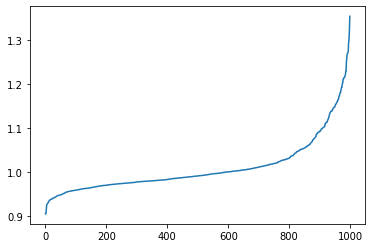

1.0092619783878327

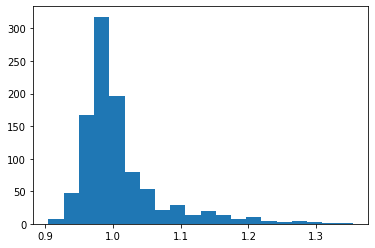

In [18]:
# asoft 64
all_cls_med = []
for cls in range(1000):
    cls_med = torch.acos(all_embeddings[all_target.eq(cls)] @ class_vectors[cls]).median()
    all_cls_med.append(cls_med.item())
plt.plot(sorted(all_cls_med));
plt.show()
plt.hist(all_cls_med, bins=20);
np.mean(all_cls_med)

In [ ]:
all_output.where()

In [ ]:
torch.where()

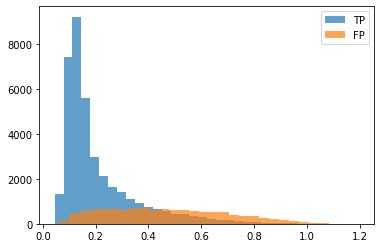

In [39]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

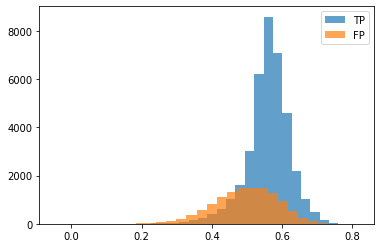

In [13]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
# pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

In [124]:
torch.Tensor.scatter_add_?

In [133]:
all_output[0, all_target[0].long()]

tensor(0.3989)

In [137]:
1 + torch.tensor(10)

tensor(11)

In [187]:
cos = np.random.rand(100)
np.median(cos) - np.cos(np.median(np.arccos(cos)))

-7.6023243250622485e-06

In [158]:
np.log(1512602)

14.229341904629822

In [139]:
all_output.scatter_add(dim=1, index=all_target.long()[..., None], src=torch.tensor(-10.0).expand(50000, 1))

tensor([[-0.1150, -0.0387, -0.0559,  ..., -0.1390, -0.0066,  0.0260],
        [ 0.0428,  0.0336, -0.0380,  ..., -0.1256, -0.0080, -0.1426],
        [ 0.1290,  0.0086,  0.0053,  ...,  0.0461, -0.0276, -0.0336],
        ...,
        [-0.0177, -0.0170, -0.0471,  ..., -0.2334,  0.0470,  0.0412],
        [ 0.0837, -0.0144, -0.1389,  ..., -0.0506, -0.0293,  0.0453],
        [ 0.0077, -0.0851, -0.0515,  ..., -0.1360, -0.0324,  0.0383]])

In [111]:
all_output.argmax(-1)

tensor([473, 635, 797,  ..., 807, 764, 683])

In [88]:
m = 0.35
np.log(382433.9062) / (0.9 - m)

23.371474769217663

In [67]:
s = 16
oo = all_output.scatter(dim=1, index=all_target.long()[..., None], value=-1)
oo.mul(16).exp().sum(-1).mean()

tensor(382433.9062)

In [107]:
m = 0.2
np.log(np.e ** (s * (1 - m)) + 3e5) / s

0.8377093284197789

In [62]:
((all_output).mul(16).exp().sum(-1)).mean()

tensor(3446204.)

In [48]:
((all_output - all_output.max(-1)[0][..., None]).mul(16).exp().sum(-1) - 1).mean()

tensor(0.2064)

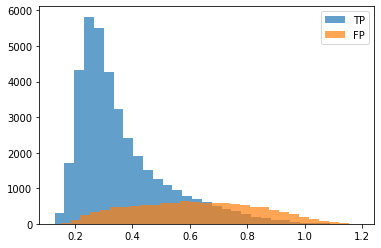

In [20]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

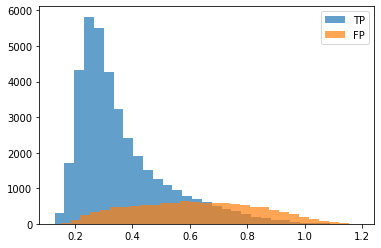

In [41]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

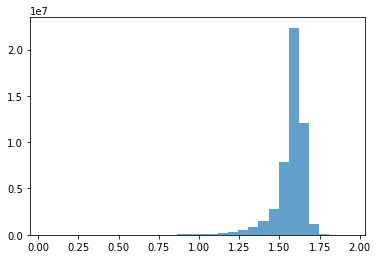

In [68]:
pos_cos = all_output.sort(-1, descending=True)[0][5:]
pos_cos = torch.acos(pos_cos)
plt.hist(pos_cos.flatten().cpu(), bins=30, alpha=0.7);

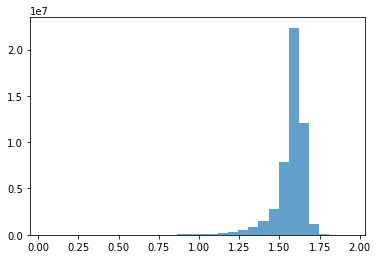

In [86]:
pos_cos = all_output.sort(-1, descending=True)[0][5:]
pos_cos = torch.acos(pos_cos)
plt.hist(pos_cos.flatten().cpu(), bins=30, alpha=0.7);

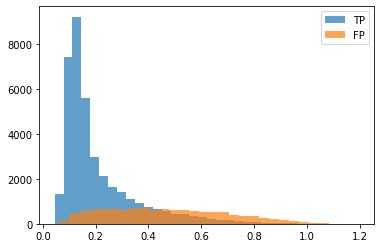

In [67]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

Median cos to positive: 0.37. 
95% percentile: 1.23


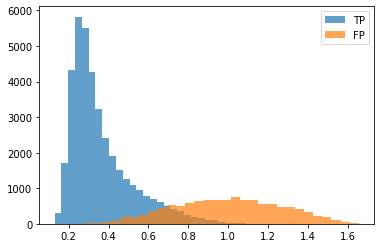

In [59]:
pos_cos = all_output.gather(-1, index=all_target[..., None].long())
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FN"]);
print(f"Median cos to positive: {pos_cos.median():.2f}. \n95% percentile: {np.percentile(pos_cos, 95):.2f}")

Median cos to positive: 0.20. 
95% percentile: 1.17


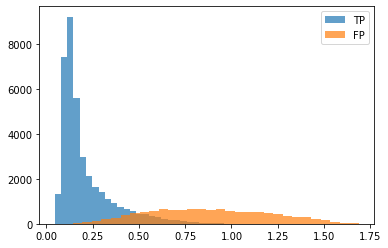

In [77]:
pos_cos = all_output.gather(-1, index=all_target[..., None].long())
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
# plt.hist(pos_cos.flatten().cpu(), bins=60, alpha=0.7);
plt.legend(["TP", "FN"]);
print(f"Median cos to positive: {pos_cos.median():.2f}. \n95% percentile: {np.percentile(pos_cos, 95):.2f}")

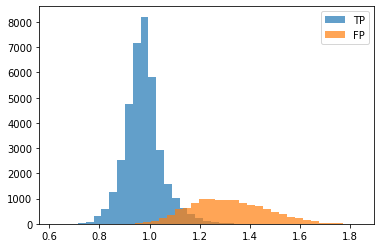

In [15]:
pos_cos = all_output.gather(-1, index=all_target[..., None].long())
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FN"]);

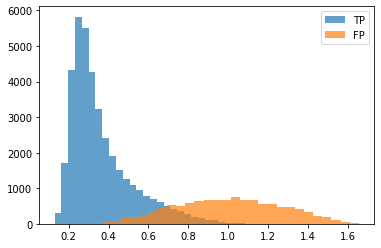

In [126]:
pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FN"]);

In [ ]:
# plot distance to positive and si

In [32]:
batch_cos.norm(dim=0)

tensor([1.8550, 1.5421, 1.4814, 1.5766, 1.3756, 1.7459, 1.7251, 1.7159, 1.6940,
        2.0770, 1.8767, 1.4806, 1.4802, 1.4650, 1.6965, 1.7383, 1.4477, 1.5670,
        1.8919, 1.5580, 1.6605, 1.5754, 1.7174, 1.8845, 1.8556, 2.8369, 2.5185,
        2.0546, 2.1087, 1.7729, 1.6569, 1.6267, 2.0831, 1.7068, 1.7761, 1.8118,
        1.8419, 1.6230, 2.2165, 1.8131, 1.7312, 1.9057, 2.4353, 2.1590, 1.9126,
        1.9223, 1.7778, 1.8690, 1.8445, 1.9278, 1.8989, 1.8082, 1.9109, 1.6680,
        1.6214, 1.7424, 1.9618, 1.7819, 1.7012, 1.6696, 1.5750, 1.6918, 2.1414,
        1.9382, 1.7275, 1.7315, 1.6541, 1.7047, 1.6840, 1.9332, 1.9180, 2.5905,
        2.8957, 2.4277, 2.5440, 2.2678, 1.7871, 1.9130, 2.2528, 1.8513, 2.0129,
        1.7382, 1.8210, 1.6881, 1.6648, 1.6734, 1.7760, 1.5272, 1.6378, 1.7153,
        1.6968, 1.9039, 1.6005, 1.9991, 1.4454, 1.7490, 1.9776, 1.5534, 1.6751,
        1.6689, 1.7835, 2.3846, 1.8878, 2.1051, 2.4380, 2.1415, 2.2520, 1.6954,
        1.5231, 1.6485, 1.5361, 2.6480, 

In [28]:
o1.norm(dim=0)

tensor([0.4100, 0.4472, 0.2351, 0.1451, 0.1674, 0.1502, 0.3837, 0.1980, 0.4269,
        0.5053, 0.3807, 0.2479, 0.2066, 0.5175, 0.2373, 0.4102, 0.3043, 0.2648,
        0.2314, 0.3211, 0.3717, 0.3692, 0.4623, 0.5045, 0.3786, 0.1511, 0.1571,
        0.2425, 0.1951, 0.1958, 0.8805, 0.2901, 0.4063, 0.2140, 0.1669, 0.2910,
        0.2850, 0.1773, 0.2033, 0.4803, 0.2584, 0.2518, 0.5887, 0.4726, 0.2810,
        0.2580, 0.1484, 0.2049, 0.2137, 0.2070, 0.2368, 0.4931, 0.3832, 0.1919,
        0.5533, 0.1786, 0.2026, 0.1389, 0.3100, 0.2016, 0.1451, 0.4688, 0.4358,
        0.3193, 0.2034, 0.1914, 0.2985, 0.2742, 0.3021, 0.2178, 0.3115, 0.1996,
        0.3086, 0.1640, 0.1793, 0.1702, 0.2055, 0.4061, 0.2835, 0.3657, 0.6916,
        0.5814, 0.4082, 0.2755, 0.3047, 0.1575, 0.5977, 0.2487, 0.3374, 0.1976,
        0.2187, 0.4313, 0.2358, 0.2287, 0.1922, 0.2482, 0.1693, 1.8039, 0.3137,
        0.4994, 0.4683, 0.2602, 0.2612, 0.2231, 0.2642, 0.2333, 0.3161, 0.2807,
        0.1397, 0.5781, 0.3915, 0.2563, 

Text(0.5, 1.0, 'PCA of features for 3 random classes on Imagenet validation')

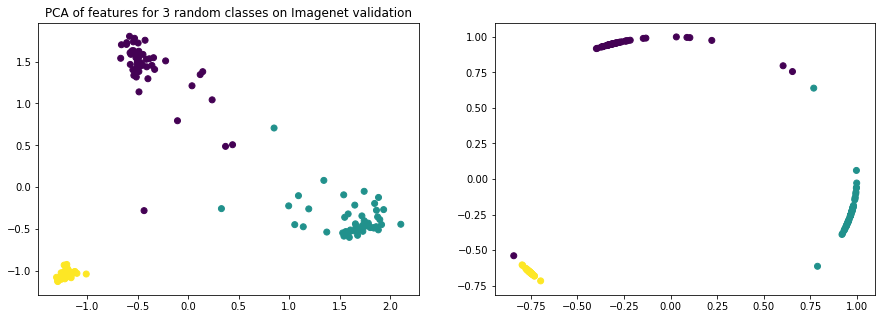

In [21]:
# best classes 364, 333, 986
# not so good 963, 749, 162
from sklearn.decomposition import PCA
o1 = all_output[all_target.eq(963)]
o2 = all_output[all_target.eq(749)]
o3 = all_output[all_target.eq(986)]
oo = torch.cat([o1, o2, o3], 0)

pca_features = PCA(n_components=2).fit_transform(oo)
pca_features_norm = torch.nn.functional.normalize(torch.from_numpy(pca_features))
c = [1,] * 50 + [2,] * 50 + [3,] * 50
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(pca_features[:, 0], pca_features[:, 1], c=c)
axes[1].scatter(pca_features_norm[:, 0], pca_features_norm[:, 1], c=c)
axes[0].set_title("PCA of features for 3 random classes on Imagenet validation")

array([[ 7.46849228e+00, -3.05177443e+00],
       [ 6.92851763e+00, -2.96389769e+00],
       [ 7.82671639e+00, -1.31563400e+00],
       [ 1.04704193e+01,  4.81692744e+00],
       [ 1.10584736e+01,  7.52003350e+00],
       [ 6.57051123e+00, -1.08018143e+01],
       [ 1.00237547e+01,  3.75395066e+00],
       [ 1.12574210e+01,  3.65190193e+00],
       [ 7.88388233e+00, -2.06737859e+00],
       [ 1.11550388e+01,  7.02196339e+00],
       [ 6.59792991e+00, -4.10734348e+00],
       [ 7.29219744e+00, -5.10455318e+00],
       [ 8.78821914e+00,  8.22988188e-02],
       [ 1.24467172e+01,  1.52503945e+00],
       [ 8.66876239e+00, -2.97684922e+00],
       [ 1.43735224e+01,  1.28035280e+01],
       [ 1.27261542e+01,  8.64873162e+00],
       [ 1.05715639e+01,  5.16966421e+00],
       [ 6.29349349e+00, -3.94712888e+00],
       [ 5.30766653e+00, -3.15453930e+00],
       [ 5.93232538e+00, -4.84796576e+00],
       [ 7.55631782e+00, -1.78924699e-01],
       [ 6.69977517e+00, -3.62988493e+00],
       [ 6.

# Model inspection

In [4]:
model_se = pt.models.resnet50(attn_type="eca")
model_sevar3 = pt.models.resnet50(attn_type="eca9")

KeyError: 'eca9'

In [8]:
count_parameters(model_se)[0], count_parameters(model_sevar3)[0]

(28088024, 45691688)

In [58]:
count(pt.modules.residual.SimpleBasicBlock(128, 128, 12))

295424

BlurPool(channels=64)

In [81]:
pt.modules.residual.FusedRepVGGBlock(32, 64, act=nn.ReLU)

FusedRepVGGBlock(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): ReLU()
)

In [25]:
"""temporary place for experiments with model. when it's mature will move this to pytorch_tools"""


"""c_model is model with Caffe-like explicit model constructor. While it makes configs
slightly larger, it also allows much greater flexibility than using separate class for each model
"""

from dataclasses import dataclass, field
from collections import OrderedDict
from typing import List, Dict, Union


import torch
import torch.nn as nn

import pytorch_tools as pt
from pytorch_tools.utils.misc import listify
from pytorch_tools.modules.residual import conv1x1, conv3x3, DropConnect
from pytorch_tools.modules import ABN


## some blocks defintion

class PreBasicBlock(nn.Module):
    """BasicBlock with preactivatoin & without downsample support"""

    def __init__(
        self, in_chs, out_chs, mid_chs=None, groups=1, groups_width=None, norm_layer=ABN, norm_act="relu", keep_prob=1,
    ):
        super().__init__()
        self.in_chs = in_chs
        self.out_chs = out_chs
        mid_chs = mid_chs or out_chs
        groups = in_chs // groups_width if groups_width else groups
        layers = [
            ("bn1", norm_layer(in_chs, activation=norm_act)),
            ("conv1", conv3x3(in_chs, mid_chs)),
            ("bn2", norm_layer(mid_chs, activation=norm_act)),
            ("conv2", conv3x3(mid_chs, out_chs)),
            ("droppath", DropConnect(keep_prob))
        ]
        self.block = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        out = self.block(x)
        if self.in_chs == self.out_chs:
            out += x
        else:
            out[:, :self.in_chs] += x
        return out

class PreInvertedResidual(nn.Module):
    def __init__(
        self,
        in_chs,
        out_chs,
        mid_chs=None,
        keep_prob=1,  # drop connect param
        norm_layer=ABN,
        norm_act="relu",
    ):
        super().__init__()
        self.in_chs = in_chs
        self.out_chs = out_chs
        mid_chs = mid_chs or out_chs
        layers = [
            ("bn1", norm_layer(in_chs, activation=norm_act)),
            ("conv_pw", conv1x1(in_chs, mid_chs)),
            ("bn2", norm_layer(mid_chs, activation=norm_act)),
            ("conv_dw", conv3x3(mid_chs, mid_chs, groups=mid_chs)),
            ("bn3", norm_layer(mid_chs, activation=norm_act)),
            ("conv_pw2", conv1x1(mid_chs, out_chs)),
            ("droppath", DropConnect(keep_prob))
        ]
        self.block = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        out = self.block(x)
        if self.in_chs == self.out_chs:
            out += x
        else:
            out[:, :self.in_chs] += x
        return out


@dataclass
class LayerDef:
    # previous layer
    prev_l: int
    # number of repeats
    n: int
    # which layer
    module: Union[str, nn.Module]
    args: List = field(default_factory=lambda: tuple())
    kwargs: Dict = field(default_factory=lambda: dict())


class Concat(nn.Module):
    def forward(self, *args):
        return torch.cat(*args, dim=1)


class CModel(nn.Module):
    """
    Args:
        features_idx (List[int]):
            from which layers to additionally save features
    """

    def __init__(
        self, layer_config: List[LayerDef], extra_kwargs: Dict[str, Dict] = None, features_idx: List[int] = None,
    ):
        super().__init__()
        if not isinstance(layer_config[0], LayerDef):
            layer_config = [LayerDef(*l) for l in layer_config]
        if extra_kwargs is not None:
            self._update_config_with_extra_params(layer_config, extra_kwargs)
        layers, saved = self._parse_config(layer_config)
        self.layers: nn.Module = layers
        self.saved: List[int] = saved

    @staticmethod
    def _update_config_with_extra_params(layer_config: List[LayerDef], extra_kwargs: Dict[str, Dict]):
        for l_name, l_kwargs in extra_kwargs.items():
            for l in layer_config:
                if l.module == l_name:
                    l.kwargs.update(**l_kwargs)
        
    @staticmethod
    def _parse_config(layer_config: List[LayerDef]):
        saved = []
        layers = []
        for l_idx, l in enumerate(layer_config):
            l.module = eval(l.module) if isinstance(l.module, str) else l.module  # eval strings
            l.args = [eval(i) if isinstance(i, str) else i for i in listify(l.args)]
            l.kwargs = {k: (eval(v) if isinstance(v, str) else v) for k, v in l.kwargs.items()}

            if l.n == 1:
                m = l.module(*l.args, **l.kwargs)
            else:
                m = nn.Sequential(*[l.module(*l.args, **l.kwargs) for _ in range(l.n)])
            # add some information about from/idx
            m.prev_l = l.prev_l
            m.idx = l_idx
            layers.append(m)
            saved.extend(l_idx + i for i in listify(l.prev_l) if i != -1)

        return nn.ModuleList(layers), saved

    def forward(self, x):
        saved_outputs: List[torch.Tensor] = []
        for layer in self.layers:
            if isinstance(layer.prev_l, list):
                x = [x if j == -1 else saved_outputs[j] for j in layer.prev_l]
            elif layer.prev_l != -1:
                x = saved_outputs[layer.prev_l]

            # print('inp', [i.shape for i in listify(x)])
            # print('saved', [i.shape for i in listify(saved_outputs) if i is not None])

            x = layer(x)
            saved_outputs.append(x if layer.idx in self.saved else None)
        return x

    def load_state_dict(self, state_dict, **kwargs):
        valid_weights = []
        for key, value in state_dict.items():
            if "num_batches_tracked" in key:
                continue
            valid_weights.append(value)
        new_sd = OrderedDict(zip(self.state_dict().keys(), valid_weights))
        super().load_state_dict(new_sd, **kwargs)


# layer_config = [
#     (-1, 1, 'pt.modules.SpaceToDepth', (2,)), # 0
#     (-1, 1, 'conv3x3', (12, 32, 2)), # 1
#     (-1, 1, conv3x3, (32, 64), {'bias': True}), # 2
#     (-2, 1, conv3x3, (32, 96)), # 3
#     ([-1, -2], 1, 'Concat'), # 4 [3, 2]
# ]


# fully matches R34
# layer_config = [
#     (-1, 1, 'Conv2d', (3, 64, 7, 2, 3), dict(bias=False)), # 0
#     (-1, 1, 'ABN', 64),
#     (-1, 1, 'torch.nn.MaxPool2d', (3, 2, 1)),
#     (-1, 3, 'pt.modules.BasicBlock', (64, 64)),
#     (-1, 1, 'pt.modules.BasicBlock', (64, 128), dict(stride=2, downsample='nn.Sequential(conv1x1(64, 128, 2), ABN(128))')),
#     (-1, 3, 'pt.modules.BasicBlock', (128, 128)),
#     (-1, 1, 'pt.modules.BasicBlock', (128, 256), dict(stride=2, downsample='nn.Sequential(conv1x1(128, 256, 2), ABN(256))')),
#     (-1, 5, 'pt.modules.BasicBlock', (256, 256)),
#     (-1, 1, 'pt.modules.BasicBlock', (256, 512), dict(stride=2, downsample='nn.Sequential(conv1x1(256, 512, 2), ABN(512))')),
#     (-1, 2, 'pt.modules.BasicBlock', (512, 512)),
#     (-1, 1, 'pt.modules.FastGlobalAvgPool2d', (), dict(flatten=True)),
#     (-1, 1, 'nn.Dropout', 0.0),
#     (-1, 1, 'nn.Linear', (512, 1000)),
# ]

# fully matches R50
# layer_config = [
#     (-1, 1, 'Conv2d', (3, 64, 7, 2, 3), dict(bias=False)), # 0
#     (-1, 1, 'ABN', 64, dict(activation="'relu'")),
#     (-1, 1, 'torch.nn.MaxPool2d', (3, 2, 1)),
#     (-1, 1, 'pt.modules.Bottleneck', (64, 64), dict(downsample="nn.Sequential(conv1x1(64, 256), ABN(256, activation='identity'))")),
#     (-1, 2, 'pt.modules.Bottleneck', (256, 64)),
#     (-1, 1, 'pt.modules.Bottleneck', (256, 128), dict(stride=2, downsample="nn.Sequential(conv1x1(256, 512, 2), ABN(512, activation='identity'))")),
#     (-1, 3, 'pt.modules.Bottleneck', (512, 128)),
#     (-1, 1, 'pt.modules.Bottleneck', (512, 256), dict(stride=2, downsample="nn.Sequential(conv1x1(512, 1024, 2), ABN(1024, activation='identity'))")),
#     (-1, 5, 'pt.modules.Bottleneck', (1024, 256)),
#     (-1, 1, 'pt.modules.Bottleneck', (1024, 512), dict(stride=2, downsample="nn.Sequential(conv1x1(1024, 2048, 2), ABN(2048, activation='identity'))")),
#     (-1, 2, 'pt.modules.Bottleneck', (2048, 512)),
#     (-1, 1, 'pt.modules.FastGlobalAvgPool2d', (), dict(flatten=True)),
#     (-1, 1, 'nn.Dropout', (), dict(p=0, inplace=False)),
#     (-1, 1, 'nn.Linear', (2048, 1000)),
# ]

layer_config = [
    (-1, 1, "pt.modules.SpaceToDepth", 2),  # 0
    (-1, 1, "conv3x3", (12, 32)),  # 0
    (-1, 1, "pt.modules.BlurPool", 32),
    (-1, 1, "PreBasicBlock", (32, 128)),
    (-1, 1, "pt.modules.BlurPool", 128),
    (-1, 1, "PreBasicBlock", (128, 192)),
    (-1, 1, "PreBasicBlock", (192, 192)),
    (-1, 1, "pt.modules.BlurPool", 192),
    (-1, 1, "PreInvertedResidual", (192, 640)),
    (-1, 5, "PreInvertedResidual", (640, 640)),
    (-1, 1, "pt.modules.BlurPool", 640),
    (-1, 1, "PreInvertedResidual", (640, 1024)),
    (-1, 4, "PreInvertedResidual", (1024, 1024)),
    (-1, 1, "pt.modules.ABN", 1024, dict(activation="'swish'")),
    (-1, 1, "conv1x1", (1024, 2560)),  # 0
    (-1, 1, "pt.modules.ABN", 2560, dict(activation="'swish'")),
    (-1, 1, "pt.modules.FastGlobalAvgPool2d", (), dict(flatten=True)),
#     (-1, 1, "nn.Dropout", (), dict(p=0, inplace=False)),
    (-1, 1, "nn.Linear", (2560, 1000)),
]


model = CModel(layer_config, extra_kwargs={'PreBasicBlock': {'norm_act': "'swish'"}, 'PreInvertedResidual': {'norm_act': "'swish'"}}) #.cuda()
# print(model)
# inp = torch.rand(4, 3, 224, 224) #.cuda()

# model(inp).shape

model

CModel(
  (layers): ModuleList(
    (0): SpaceToDepth(block_size=2)
    (1): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BlurPool(channels=32)
    (3): PreBasicBlock(
      (block): Sequential(
        (bn1): ABN(32, eps=1e-05, momentum=0.1, affine=True, activation=ACT.SWISH)
        (conv1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): ABN(128, eps=1e-05, momentum=0.1, affine=True, activation=ACT.SWISH)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (droppath): DropConnect(keep_prob=1.00)
      )
    )
    (4): BlurPool(channels=128)
    (5): PreBasicBlock(
      (block): Sequential(
        (bn1): ABN(128, eps=1e-05, momentum=0.1, affine=True, activation=ACT.SWISH)
        (conv1): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): ABN(192, eps=1e-05, momentum=0.1, affine=True, activation=ACT.

In [26]:
count(model)

NameError: name 'count' is not defined

In [102]:
r34 = pt.models.resnet50(pretrained='imagenet').cuda()
# r34

In [105]:
sd = torch.load("/home/zakirov/repoz/sota_imagenet/logs/r50_baseline_2021-06-28/15-06-09/model.chpn")['state_dict']
r34.load_state_dict(sd)

In [106]:
for n ,p in r34.named_parameters():
    if 'bn' in n:
        print(p.shape, round(p.mean().item(), 2))

torch.Size([64]) 2.63
torch.Size([64]) 2.58
torch.Size([64]) 1.62
torch.Size([64]) 0.44
torch.Size([64]) 1.37
torch.Size([64]) 0.84
torch.Size([256]) -0.15
torch.Size([256]) -0.02
torch.Size([64]) 2.22
torch.Size([64]) -0.5
torch.Size([64]) 2.11
torch.Size([64]) 0.13
torch.Size([256]) 0.07
torch.Size([256]) -0.22
torch.Size([64]) 2.16
torch.Size([64]) -0.23
torch.Size([64]) 2.22
torch.Size([64]) -0.3
torch.Size([256]) -0.05
torch.Size([256]) -0.49
torch.Size([128]) 2.64
torch.Size([128]) -2.04
torch.Size([128]) 2.37
torch.Size([128]) -0.36
torch.Size([512]) 0.06
torch.Size([512]) -0.03
torch.Size([128]) 1.59
torch.Size([128]) 0.34
torch.Size([128]) 2.59
torch.Size([128]) -1.32
torch.Size([512]) 0.02
torch.Size([512]) -0.62
torch.Size([128]) 2.03
torch.Size([128]) -0.77
torch.Size([128]) 2.23
torch.Size([128]) -0.91
torch.Size([512]) -0.08
torch.Size([512]) -0.95
torch.Size([128]) 2.01
torch.Size([128]) -1.81
torch.Size([128]) 1.88
torch.Size([128]) -0.92
torch.Size([512]) -0.0
torch.Si

In [104]:
for n ,p in r34.named_parameters():
    if 'bn' in n:
        print(p.shape, round(p.mean().item(), 2))

torch.Size([64]) 0.26
torch.Size([64]) 0.21
torch.Size([64]) 0.19
torch.Size([64]) 0.03
torch.Size([64]) 0.16
torch.Size([64]) 0.11
torch.Size([256]) 0.13
torch.Size([256]) 0.03
torch.Size([64]) 0.18
torch.Size([64]) -0.02
torch.Size([64]) 0.18
torch.Size([64]) -0.0
torch.Size([256]) 0.08
torch.Size([256]) 0.0
torch.Size([64]) 0.18
torch.Size([64]) -0.02
torch.Size([64]) 0.22
torch.Size([64]) -0.05
torch.Size([256]) 0.07
torch.Size([256]) -0.01
torch.Size([128]) 0.21
torch.Size([128]) -0.07
torch.Size([128]) 0.2
torch.Size([128]) 0.02
torch.Size([512]) 0.1
torch.Size([512]) 0.02
torch.Size([128]) 0.12
torch.Size([128]) 0.04
torch.Size([128]) 0.16
torch.Size([128]) 0.0
torch.Size([512]) 0.08
torch.Size([512]) -0.02
torch.Size([128]) 0.17
torch.Size([128]) 0.0
torch.Size([128]) 0.18
torch.Size([128]) -0.01
torch.Size([512]) 0.1
torch.Size([512]) -0.06
torch.Size([128]) 0.17
torch.Size([128]) -0.03
torch.Size([128]) 0.2
torch.Size([128]) -0.06
torch.Size([512]) 0.09
torch.Size([512]) -0.0

In [96]:
r34.last_linear.bias.max()

tensor(0.0371, device='cuda:0', grad_fn=<MaxBackward1>)

In [58]:
model

CModel(
  (layers): ModuleList(
    (0): SpaceToDepth(block_size=2)
    (1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BlurPool(channels=64)
    (3): Sequential(
      (0): FusedRepVGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): SELU()
      )
      (1): FusedRepVGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): SELU()
      )
      (2): FusedRepVGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): SELU()
      )
      (3): FusedRepVGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): SELU()
      )
      (4): FusedRepVGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): SELU()
      )
      (5): FusedRepVGGBlock(
        (conv): Conv2d(6

In [55]:
%timeit model(inp)

6.94 ms ± 4.33 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit r34(inp)

8.34 ms ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
count(model), count(r34)

(21613672, 21797672)

In [49]:
model.load_state_dict(r34.state_dict())

In [50]:
# out1 = r34.features(inp)
out1 = r34(inp)
out2 = model(inp)
assert torch.allclose(out1, out2)
assert count(model) == count(r34)

In [51]:
(out1 - out2).max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [226]:
from enum import Enum

class Typ(Enum):
    SOME = 'some'
    ANY = 'any'
    
    
Typ(Typ('any'))

<Typ.ANY: 'any'>

In [4]:
import os
import shutil
import subprocess as sp
from loguru import logger


def get_gminer(update: bool = False):
    """Download, extract and move gminer to current workdir"""
    if not update and "gm" in os.listdir():
        logger.info("Skip dowload. Pass `update` to get newer version")
        return
    logger.info("Downloading gminer")
    cur_dir = os.getcwd()
    shutil.rmtree("/tmp/gm/", ignore_errors=True)
    os.makedirs("/tmp/gm/", exist_ok=True)
    os.chdir("/tmp/gm/")
    RP = "https://api.github.com/repos/develsoftware/GMinerRelease/releases/latest"  # releases page
    sp.run(f'curl -s {RP} | grep -E "browser_download_url" | grep linux64 | cut -d \'"\' -f 4 | wget -qi -', shell=True)
    sp.run(f"tar xf gminer* && mv miner {cur_dir + '/gm'}", shell=True)
    os.chdir(cur_dir)
           
get_gminer()

2021-07-09 20:54:30.737 | INFO     | __main__:get_gminer:12 - Downloading gminer


In [304]:
import arrow
from typing import List, Tuple
from datetimerange import DateTimeRange

In [284]:
arrow.get('Mon', 'ddd').isoweekday()

1

In [302]:
def str_to_weekday(day: str) -> int:
    return arrow.get(day, 'ddd').isoweekday()

def true_now() -> arrow.Arrow:
    # some machines have wrong timezone. get true time as UTC + Moscow offset
    return arrow.utcnow().shift(hours=3)

def parse_time_range(time_ranges: str) -> List[DayTimeRange]:
    """time_ranges like  '00:02-10:05,21:00-23:59' """
    n = true_now().floor('day')
    # 00:02-10:05,21:00-23:59 -> [[00:02, 10:05], [00:02, 10:05]]
    intervals = [i.split('-') for i in time_ranges.split(',')]
    intervals = [(arrow.get(s,"HH:mm"), arrow.get(e,"HH:mm")) for (s,e) in intervals]
    # get times as shifts from start of the day
    intervals = [(n.shift(hours=s.hour, minutes=s.minute), n.shift(hours=e.hour, minutes=e.minute)) for (s, e) in intervals]
    # turn it into real ranges
    intervals = [DateTimeRange(str(s), str(e)) for (s, e) in intervals]
    return intervals
    
def is_in_time_range(time_ranges: List[DayTimeRange]) -> bool:
    n = true_now()
    return any(n in tr for tr in time_ranges)

schedule = [
    ['Mon', '00:01-10:00,22:00-23:59'],
    ['Tue', '00:02-10:00,22:00-23:59'], 
    ['Wed', '00:03-10:00,22:00-23:59'], 
    ['Thu', '00:04-10:00,22:00-23:59'], 
    ['Fri', '00:05-10:00,22:00-23:59'], 
    ['Sat', '00:00-23:59'], 
    ['Sun', '00:00-23:59'], 
]

schedule_dict = {str_to_weekday(wd): parse_time_range(tr) for (wd, tr) in schedule}
schedule_dict[true_now().isoweekday()]
# ss = '00:02-10:05,21:00-23:59'
# is_in_time_range(parse_time_range(ss))

[2021-07-09T00:05:00+0000 - 2021-07-09T10:00:00+0000,
 2021-07-09T22:00:00+0000 - 2021-07-09T23:59:00+0000]

In [295]:
str_to_weekday('Sun')

7

In [305]:
schedule: List[Tuple[str, str]] = [
    ['Mon', '00:01-10:00,22:00-23:59'],
    ['Tue', '00:02-10:00,22:00-23:59'], 
    ['Wed', '00:03-10:00,22:00-23:59'], 
    ['Thu', '00:04-10:00,22:00-23:59'], 
    ['Fri', '00:05-10:00,22:00-23:59'], 
    ['Sat', '00:00-23:59'], 
    ['Sun', '00:00-23:59'], 
]

In [312]:
import subprocess
from typing import Set

In [319]:
bool({'set.difference'})

True

In [318]:
WHITE_LIST = {'zakirov', 'rod'}
def get_logged_users() -> Set[str]:
    all_users = subprocess.run(['users'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    unique_users = set(all_users.strip().split(' '))
    return unique_users

get_logged_users().difference(WHITE_LIST)

set()

In [306]:
dd = 'sdfasddsafd'
d

NameError: name 'dd' is not defined

In [157]:
from datetimerange import DateTimeRange
time_range = DateTimeRange("2013-03-22T10:00:00+0900", "2015-03-22T10:10:00+0900")
str(time_range)

'2013-03-22T10:00:00+0900 - 2015-03-22T10:10:00+0900'

In [269]:
n.floor('day')

<Arrow [2021-07-09T00:00:00+00:00]>

1

In [265]:
type(tr)

datetimerange.DateTimeRange

In [241]:
tr = DateTimeRange('14:10', '23:11', start_time_format='%H:%M', end_time_format='%H:%M')

In [243]:
tr.start_datetime

datetime.datetime(2021, 7, 9, 14, 10)

datetime.datetime(2021, 7, 9, 23, 5, 0, 110571)

14:10 - 02:00

In [218]:
import datetime
from datetime import datetime as dt

In [219]:
datetime.timedelta(hours = 10)

datetime.timedelta(0, 36000)

In [228]:
dt.utcnow() + datetime.timedelta(hours=3)

datetime.datetime(2021, 7, 9, 23, 10, 37, 944429)

In [234]:
tr = DateTimeRange('14:10', '23:11', start_time_format='%H:%M', end_time_format='%H:%M')
print(tr)
dt.now() in tr

14:10 - 23:11


True

In [189]:
from dataclasses import dataclass

# @dataclass
# class DayTimeRange:
#     isoweekday: int
#     some: float = 1.
        


2021-07-09T14:10:00 - 2021-07-09T22:00:00

In [179]:
st = arrow.get('12:32', 'HH:mm')

In [180]:
fd = arrow.utcnow().floor('day')

In [181]:
fd.shift(hours=st.hour, minutes=st.minute)

<Arrow [2021-07-09T12:32:00+00:00]>

In [158]:
dt = arrow.get('2013-05-05 12:30:45', 'YYYY-MM-DD HH:mm:ss').datetime

In [159]:
dt in time_range

True

In [152]:
time_range

2015-03-22T10:00:00+0900 - 2015-03-22T10:10:00+0900

In [74]:
import arrow

In [76]:
arrow.get('2013-05-05 12:30:45', 'YYYY-MM-DD HH:mm:ss')


<Arrow [2013-05-05T12:30:45+00:00]>

In [93]:
arrow.get('02:00', "HH:mm").datetime

datetime.datetime(1, 1, 1, 2, 0, tzinfo=tzutc())

In [87]:
a = arrow.utcnow()
a

<Arrow [2021-07-09T19:29:44.017134+00:00]>

In [ ]:
arrow.Arrow.

In [150]:
arrow.Arrow.range('minute', start, end)

<generator object Arrow.range at 0x7fd1bee16a40>

In [149]:
start = datetime(2013, 5, 5, 12, 30)
end = datetime(2013, 5, 5, 17, 15)
for r in arrow.Arrow.range('minute', start, end):
    print(r)


2013-05-05T12:30:00+00:00
2013-05-05T12:31:00+00:00
2013-05-05T12:32:00+00:00
2013-05-05T12:33:00+00:00
2013-05-05T12:34:00+00:00
2013-05-05T12:35:00+00:00
2013-05-05T12:36:00+00:00
2013-05-05T12:37:00+00:00
2013-05-05T12:38:00+00:00
2013-05-05T12:39:00+00:00
2013-05-05T12:40:00+00:00
2013-05-05T12:41:00+00:00
2013-05-05T12:42:00+00:00
2013-05-05T12:43:00+00:00
2013-05-05T12:44:00+00:00
2013-05-05T12:45:00+00:00
2013-05-05T12:46:00+00:00
2013-05-05T12:47:00+00:00
2013-05-05T12:48:00+00:00
2013-05-05T12:49:00+00:00
2013-05-05T12:50:00+00:00
2013-05-05T12:51:00+00:00
2013-05-05T12:52:00+00:00
2013-05-05T12:53:00+00:00
2013-05-05T12:54:00+00:00
2013-05-05T12:55:00+00:00
2013-05-05T12:56:00+00:00
2013-05-05T12:57:00+00:00
2013-05-05T12:58:00+00:00
2013-05-05T12:59:00+00:00
2013-05-05T13:00:00+00:00
2013-05-05T13:01:00+00:00
2013-05-05T13:02:00+00:00
2013-05-05T13:03:00+00:00
2013-05-05T13:04:00+00:00
2013-05-05T13:05:00+00:00
2013-05-05T13:06:00+00:00
2013-05-05T13:07:00+00:00
2013-05-05T1

In [148]:
!pip install datetimerange

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [135]:
class

5

In [147]:
now = arrow.utcnow().shift(hours=3)
now.isoweekday()

5

In [ ]:
ss = 'Mon 00:00-10:00,22:00-23:59'
ss.

In [130]:
arrow.get("Mon", "ddd").datetime.isoweekday()

1

In [98]:
arrow.get('00:00', "HH:mm") - arrow.get('02:00', "HH:mm")

datetime.timedelta(-1, 79200)

['00:00-10:00', '21:00-24:00']

In [61]:
gpus_util = [i.gpu_util for i in nvsmi.get_gpus()]
[idx for idx, util in enumerate(gpus_util) if util == 0]


[]

In [56]:
ss = list(nvsmi.get_gpus())
ss[0]

id: 0 | UUID: GPU-8b832400-dafc-234e-fe65-5e9644f14d83 | gpu_util:  96.0% | mem_util:  41.4% | mem_free: 19060.0MB |  mem_total: 32510.0MB

In [49]:
!nvidia-smi

Fri Jul  9 21:33:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:01:00.0 Off |                    0 |
| N/A   59C    P0   284W / 300W |  13450MiB / 32510MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:02:00.0 Off |                    0 |
| N/A   

In [34]:
# def get_free_gpus():
res = sp.run("nvidia-smi --query-gpu=utilization.gpu --format=csv", shell=True, stdout=sp.PIPE)
res = res.stdout.decode("utf-8").split('\n')[1:]
res

['97 %', '97 %', '94 %', '83 %', '']